# Calculating Climatology and Departures from Time Series Data

Author: [Tom Vo](https://github.com/tomvothecoder/) & [Jiwoo Lee](https://github.com/lee1043/)

Updated: 03/14/25 [xcdat v0.8.0]

Related APIs:

- [xarray.Dataset.temporal.climatology()](../generated/xarray.Dataset.temporal.climatology.rst)
- [xarray.Dataset.temporal.departures()](../generated/xarray.Dataset.temporal.departures.rst)


## Overview

Suppose we have two netCDF4 files for air temperature data (`tas`).

- File 1: Monthly frequency from 1850-01-16 to 1874-12-31
  - We want to calculate the annual and seasonal cycle climatologies and departures using this file.
- File 2: Hourly frequency from 2010-01-01 to 2014-12-31
  - We want to calculate the daily cycle climatologies and departures using this file.

The data used in this example can be found in the [xcdat-data repository](https://github.com/xCDAT/xcdat-data).


### Notebook Kernel Setup

Users can [install their own instance of xcdat](../getting-started-guide/installation.rst) and follow these examples using their own environment (e.g., with VS Code, Jupyter, Spyder, iPython) or [enable xcdat with existing JupyterHub instances](../getting-started-guide/getting-started-hpc-jupyter.rst).

First, create the conda environment:

```bash
conda create -n xcdat_notebook -c conda-forge xcdat xesmf matplotlib ipython ipykernel cartopy nc-time-axis gsw-xarray jupyter pooch
```

Then install the kernel from the `xcdat_notebook` environment using `ipykernel` and name the kernel with the display name (e.g., `xcdat_notebook`):

```bash
python -m ipykernel install --user --name xcdat_notebook --display-name xcdat_notebook
```

Then to select the kernel `xcdat_notebook` in Jupyter to use this kernel.


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import xcdat as xc

## 1. Open Sample Datasets


### File 1: Monthly Frequency


In [2]:
ds = xc.tutorial.open_dataset("tas_amon_access", use_cftime=True)

# Unit adjust (-273.15, K to C)
ds["tas"] = ds.tas - 273.15

ds_monthly = ds.copy()
ds_monthly

<xarray.Dataset> Size: 7MB
Dimensions:    (time: 60, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * lat        (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
    height     float64 8B 2.0
  * time       (time) object 480B 1870-01-16 12:00:00 ... 1874-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 960B ...
    lat_bnds   (lat, bnds) float64 2kB ...
    lon_bnds   (lon, bnds) float64 3kB ...
    tas        (time, lat, lon) float32 7MB -29.36 -29.36 ... -31.07 -31.07
Attributes: (12/48)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           87658.0
    creation_date:                   2020-06-05T04:06:11Z
    ...                              ...
    variant_label:                   r10i1p1f1
    version:                         v20200605
    license:                         CMIP6 model data produced by CSIRO is li...
    cmor_version:                    3.4.0
    tracking_id:                     hdl:21.14100/af78ae5e-f3a6-4e99-8cfe-5f2...
    DODS_EXTRA.Unlimited_Dimension:  time

### 2: Hourly Frequency


In [3]:
ds_hourly = xc.tutorial.open_dataset("tas_3hr_access", add_bounds="T")

# Unit adjust (-273.15, K to C)
ds_hourly["tas"] = ds_hourly.tas - 273.15
ds_hourly

<xarray.Dataset> Size: 25MB
Dimensions:    (lat: 25, bnds: 2, lon: 17, time: 14608)
Coordinates:
  * lat        (lat) float64 200B 15.0 16.25 17.5 18.75 ... 42.5 43.75 45.0
  * lon        (lon) float64 136B 15.0 16.88 18.75 20.62 ... 41.25 43.12 45.0
    height     float64 8B 2.0
  * time       (time) object 117kB 2010-01-01 03:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 400B ...
    lon_bnds   (lon, bnds) float64 272B ...
    tas        (time, lat, lon) float32 25MB 12.32 13.32 14.73 ... 0.9856 1.557
    time_bnds  (time, bnds) object 234kB 2010-01-01 03:00:00 ... 2015-01-01 0...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  87658.0
    creation_date:          2020-06-05T04:54:56Z
    ...                     ...
    variable_id:            tas
    variant_label:          r10i1p1f1
    version:                v20200605
    license:                CMIP6 model data produced by CSIRO is licensed un...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/b79e6a05-c482-46cf-b3b8-83b9a7d0cfdd

## 2. Calculate Climatology

Related API: [xarray.Dataset.temporal.climatology()](../generated/xarray.Dataset.temporal.climatology.rst)

In this example, we will be calculating the weighted climatology of the `tas` variable for its seasonal, annual, and daily cycles.

Helpful knowledge:

- Masked (missing) data is automatically handled.
  - The weight of masked (missing) data is excluded when averages are calculated. This is the same as giving them a weight of 0.
- If desired, use the `reference_period` argument to calculate a climatology based on a
  climatological reference period (a subset of the entire time series). If no value is
  provided, the climatological reference period will be the full period covered by the
  dataset.


### Seasonal Climatology

**Groups time coordinates by season**

The `season_config` dictionary keyword argument can be passed to `.climatology()` for more granular configuration. We will be sticking with the default settings.


In [4]:
season_climo = ds_monthly.temporal.climatology(
    "tas",
    freq="season",
    weighted=True,
    season_config={"dec_mode": "DJF", "drop_incomplete_djf": True},
)

Text(0.5, 1.02, 'Seasonal Surface Air Temperature')

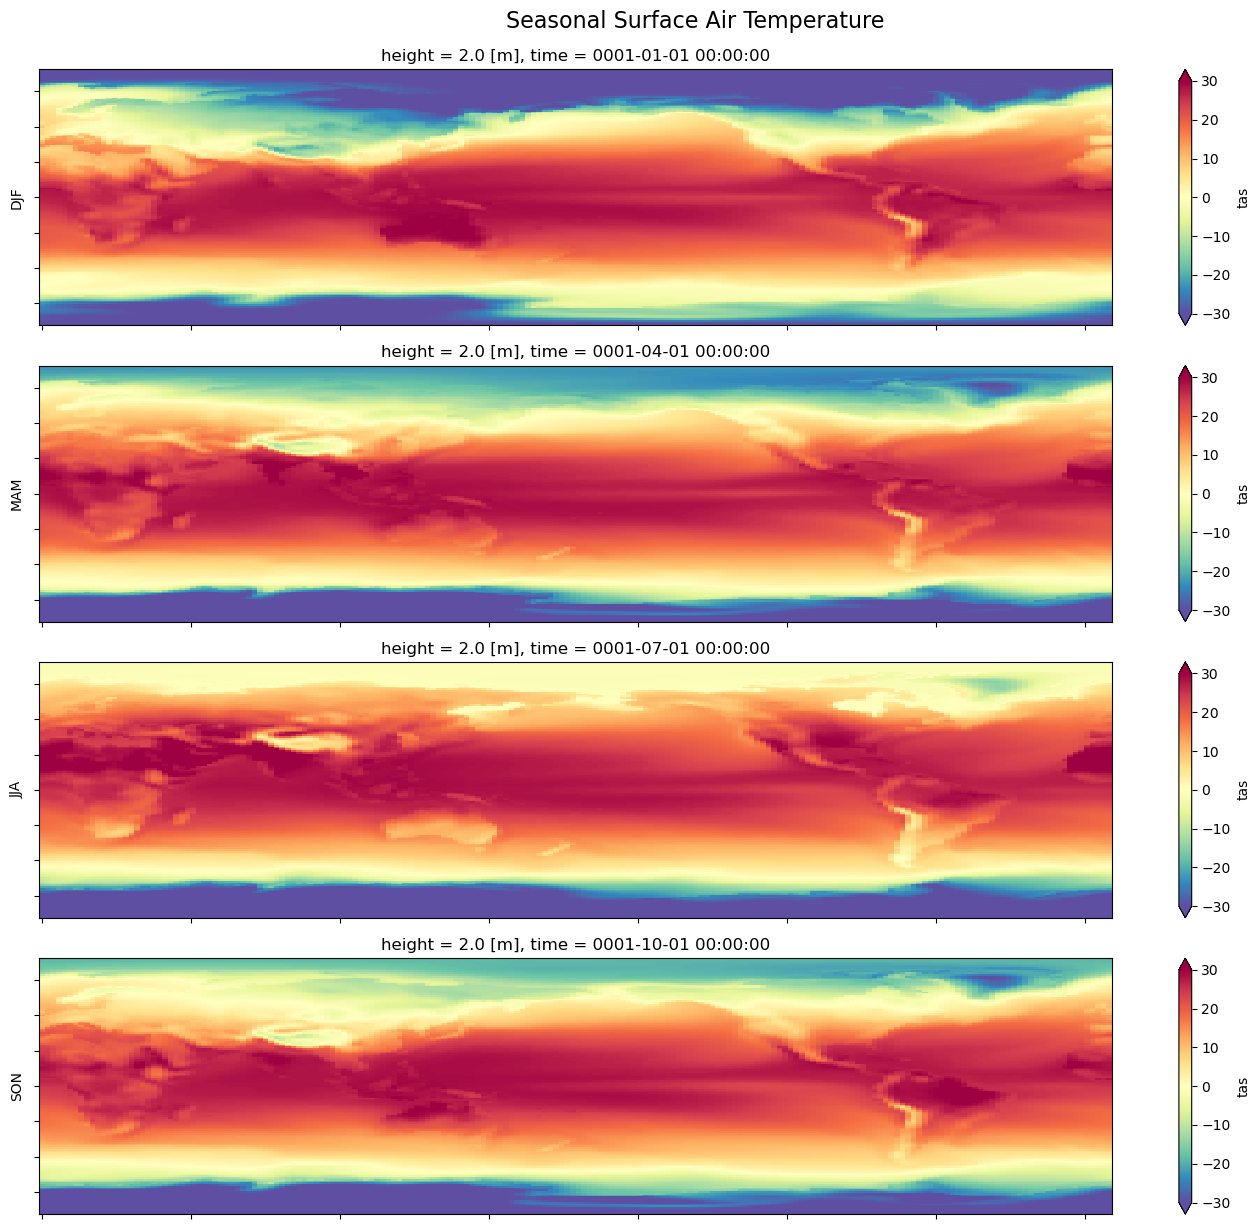

In [5]:
notnull = pd.notnull(season_climo["tas"][0])
tas_season = season_climo.tas

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
for i, season in enumerate(("DJF", "MAM", "JJA", "SON")):
    tas_season.isel(time=i).where(notnull).plot.pcolormesh(
        ax=axes[i],
        vmin=-30,
        vmax=30,
        cmap="Spectral_r",
        add_colorbar=True,
        extend="both",
    )
    axes[i].set_ylabel(season)

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")

plt.tight_layout()
fig.suptitle("Seasonal Surface Air Temperature", fontsize=16, y=1.02)

Notice that the time coordinates are `cftime` objects, with each season ("DJF", "MAM", "JJA", and "SON") represented by its middle month.

`cftime` objects are used because the time coordinates are outside the Timestamp-valid range (approximately between years 1678 and 2262).

- More info here: https://xarray.pydata.org/en/v2022.03.0/user-guide/weather-climate.html#non-standard-calendars-and-dates-outside-the-timestamp-valid-range


In [6]:
season_climo.time

<xarray.DataArray 'time' (time: 4)> Size: 32B
array([cftime.DatetimeProlepticGregorian(1, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(1, 10, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
    height   float64 8B 2.0
  * time     (time) object 32B 0001-01-01 00:00:00 ... 0001-10-01 00:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time
    _ChunkSizes:    1

### Custom Seasonal Climatology

**Groups time coordinates by season**

To calculate custom seasonal cycle climatology, we must first define our custom seasons using the `season_config` dictionary and the `"custom_seasons"` key.

`"custom_seasons"` must be a list of sublists containing month strings, with each sublist
representing a custom season.

- Month strings must be in the three letter format (e.g., 'Jan')
- Each month must be included once in a custom season
- Order of the months in each custom season does not matter
- Custom seasons can vary in length


In [7]:
custom_seasons = [
    ["Jan", "Feb", "Mar"],  # "JanFebMar"
    ["Apr", "May", "Jun"],  # "AprMayJun"
    ["Jul", "Aug", "Sep"],  # "JunJulAug"
    ["Oct", "Nov", "Dec"],  # "OctNovDec"
]

c_season_climo = ds_monthly.temporal.climatology(
    "tas",
    freq="season",
    weighted=True,
    season_config={"custom_seasons": custom_seasons},
)

In [8]:
c_season_climo.tas

<xarray.DataArray 'tas' (time: 4, lat: 145, lon: 192)> Size: 891kB
array([[[-39.19532013, -39.19532013, -39.19532013, ..., -39.19532013,
         -39.19532013, -39.19532013],
        [-37.01573944, -37.04970169, -37.08385849, ..., -36.91618729,
         -36.94950867, -36.98220444],
        [-36.18674469, -36.29411697, -36.40126038, ..., -35.86174393,
         -35.97014999, -36.07756042],
        ...,
        [-33.77421951, -33.72594452, -33.67987442, ..., -33.93065262,
         -33.8719902 , -33.82394409],
        [-33.88726044, -33.86452866, -33.84161377, ..., -33.96446609,
         -33.93911743, -33.91221619],
        [-34.45789719, -34.45789719, -34.45789719, ..., -34.45789719,
         -34.45789719, -34.45789719]],

       [[-56.66869736, -56.66869736, -56.66869736, ..., -56.66869736,
         -56.66869736, -56.66869736],
        [-52.51451492, -52.56056595, -52.60503387, ..., -52.37384796,
         -52.4212532 , -52.46620178],
        [-51.41792679, -51.53495407, -51.64799118, ..., -51.03515244,
         -51.16582108, -51.29377365],
...
        [ -4.33746576,  -4.34009361,  -4.33881092, ...,  -4.33952332,
          -4.33847046,  -4.33966684],
        [ -4.34618855,  -4.34531164,  -4.3482523 , ...,  -4.34492779,
          -4.35151768,  -4.35107231],
        [ -4.43647957,  -4.43647957,  -4.43647957, ...,  -4.43647957,
          -4.43647957,  -4.43647957]],

       [[-38.69176865, -38.69176865, -38.69176865, ..., -38.69176865,
         -38.69176865, -38.69176865],
        [-36.53458786, -36.5655098 , -36.59703064, ..., -36.44615936,
         -36.47403336, -36.50304413],
        [-35.67700195, -35.77786636, -35.87950897, ..., -35.37251282,
         -35.47246933, -35.57453918],
        ...,
        [-25.41450691, -25.35720825, -25.29871559, ..., -25.59947968,
         -25.53376579, -25.47436333],
        [-25.7094574 , -25.68809891, -25.66363525, ..., -25.78791618,
         -25.76446152, -25.73705673],
        [-26.46623611, -26.46623611, -26.46623611, ..., -26.46623611,
         -26.46623611, -26.46623611]]])
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B 2.0
  * time     (time) object 32B 0001-02-01 00:00:00 ... 0001-11-01 00:00:00
Attributes:
    operation:                temporal_avg
    mode:                     climatology
    freq:                     season
    weighted:                 True
    drop_incomplete_seasons:  False
    custom_seasons:           ['JanFebMar', 'AprMayJun', 'JulAugSep', 'OctNov...

Text(0.5, 1.02, 'Seasonal Surface Air Temperature')

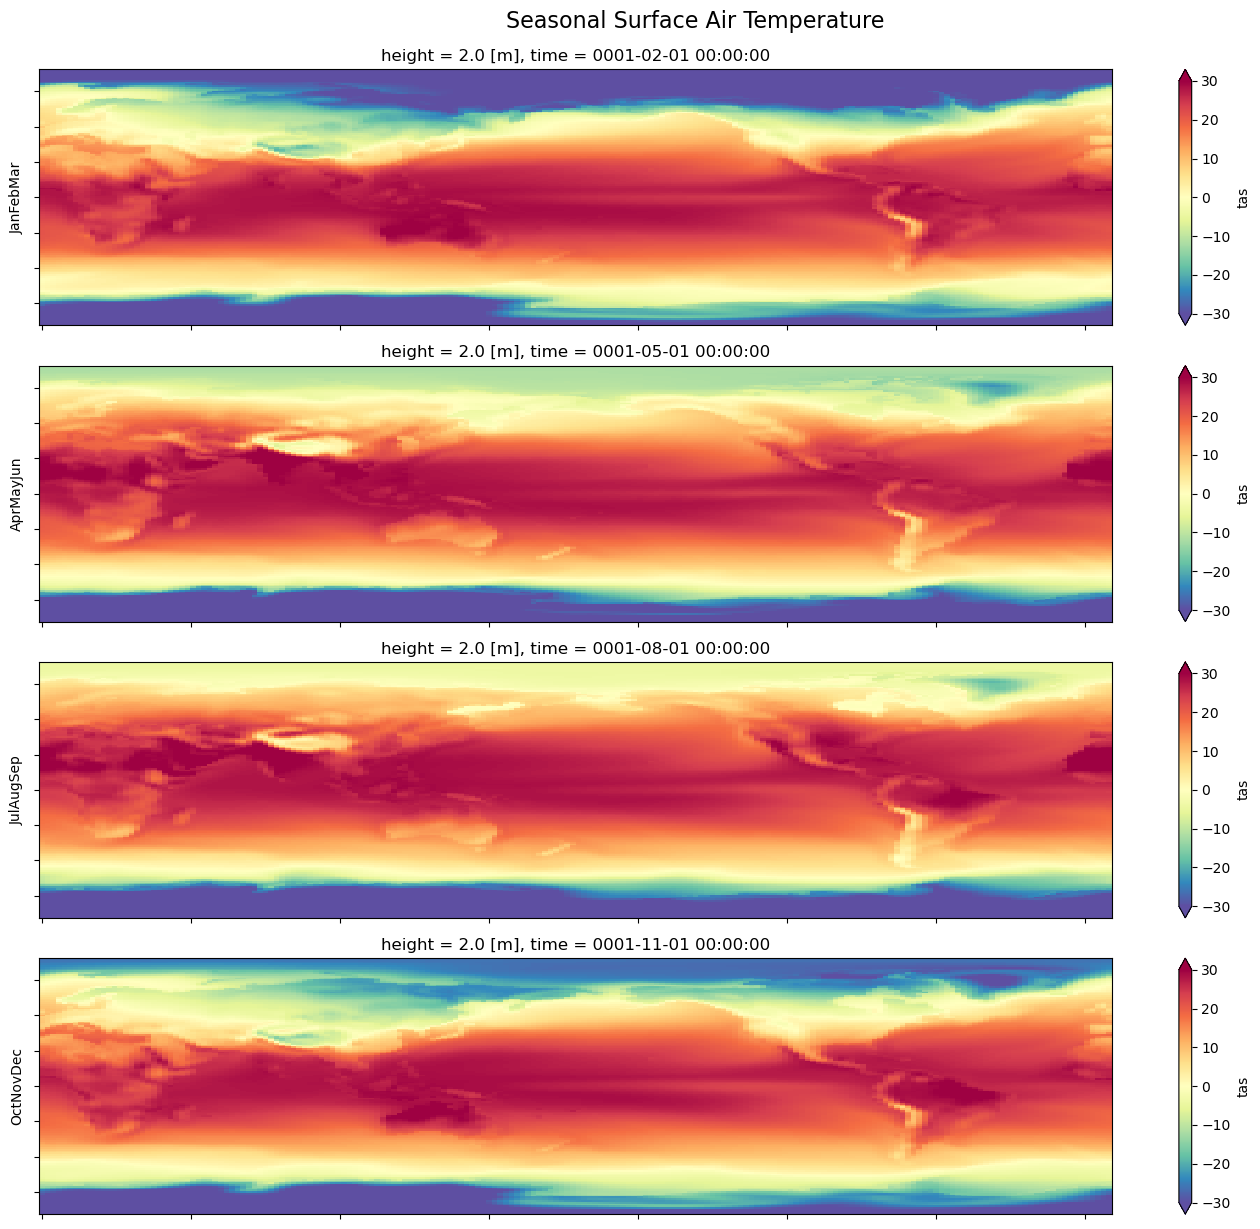

In [9]:
notnull = pd.notnull(c_season_climo["tas"][0])
tas_c_season = c_season_climo.tas

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 12))
for i, season in enumerate(tas_c_season.attrs["custom_seasons"]):
    tas_c_season.isel(time=i).where(notnull).plot.pcolormesh(
        ax=axes[i],
        vmin=-30,
        vmax=30,
        cmap="Spectral_r",
        add_colorbar=True,
        extend="both",
    )
    axes[i].set_ylabel(season)

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")

plt.tight_layout()
fig.suptitle("Seasonal Surface Air Temperature", fontsize=16, y=1.02)

### Annual Climatology

**Groups time coordinates by month**


In [10]:
annual_climo = ds_monthly.temporal.climatology("tas", freq="month", weighted=True)

In [11]:
annual_climo.tas

<xarray.DataArray 'tas' (time: 12, lat: 145, lon: 192)> Size: 3MB
array([[[-29.06313705, -29.06313705, -29.06313705, ..., -29.06313705,
         -29.06313705, -29.06313705],
        [-28.08530235, -28.11272812, -28.14105415, ..., -28.01033974,
         -28.03586197, -28.05913353],
        [-27.52668381, -27.62425613, -27.72285843, ..., -27.22868156,
         -27.326931  , -27.42668152],
        ...,
        [-33.98196411, -33.93555069, -33.89547729, ..., -34.13406372,
         -34.07303238, -34.02735901],
        [-33.84999084, -33.82824707, -33.80555725, ..., -33.92643738,
         -33.90127945, -33.87459183],
        [-34.257267  , -34.257267  , -34.257267  , ..., -34.257267  ,
         -34.257267  , -34.257267  ]],

       [[-37.60506439, -37.60506439, -37.60506439, ..., -37.60506439,
         -37.60506439, -37.60506439],
        [-36.16939926, -36.2160759 , -36.2623558 , ..., -36.02677917,
         -36.07527161, -36.12286377],
        [-35.75842667, -35.87947083, -36.00115204, ..., -35.38283539,
         -35.5104866 , -35.63329315],
...
        [-24.32939911, -24.24647331, -24.155159  , ..., -24.5884037 ,
         -24.50076294, -24.41546249],
        [-24.88113976, -24.85075569, -24.81808472, ..., -24.99034882,
         -24.95741653, -24.92110443],
        [-25.88207817, -25.88207817, -25.88207817, ..., -25.88207817,
         -25.88207817, -25.88207817]],

       [[-28.29774857, -28.29774857, -28.29774857, ..., -28.29774857,
         -28.29774857, -28.29774857],
        [-27.16428185, -27.19420052, -27.2231102 , ..., -27.07938766,
         -27.10679245, -27.13484001],
        [-26.44675827, -26.54774094, -26.64871025, ..., -26.14484024,
         -26.24298477, -26.34383011],
        ...,
        [-31.27905464, -31.22894287, -31.1820488 , ..., -31.44397545,
         -31.38128471, -31.33101273],
        [-31.66051483, -31.63742447, -31.61308861, ..., -31.73810959,
         -31.71916199, -31.68753624],
        [-32.59217453, -32.59217453, -32.59217453, ..., -32.59217453,
         -32.59217453, -32.59217453]]])
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B 2.0
  * time     (time) object 96B 0001-01-01 00:00:00 ... 0001-12-01 00:00:00
Attributes:
    operation:  temporal_avg
    mode:       climatology
    freq:       month
    weighted:   True

### Daily Climatology

**Groups time coordinates by month and day.**

Leap days (if present) are dropped if the CF calendar type is `"gregorian"`, `"proleptic_gregorian"`, or `"standard"`.


In [12]:
daily_climo = ds_hourly.temporal.climatology("tas", freq="day", weighted=True)

In [13]:
daily_climo.tas

<xarray.DataArray 'tas' (time: 365, lat: 25, lon: 17)> Size: 1MB
array([[[17.27717972, 18.28470039, 20.56212997, ..., 24.01642036,
         22.2651577 , 18.01205444],
        [15.63191414, 16.40312004, 18.61579514, ..., 25.43622398,
         21.73271751, 17.26057434],
        [15.77403927, 16.43821526, 16.8564167 , ..., 25.21095467,
         19.33696747, 14.54894066],
        ...,
        [10.21639633, 11.54874611,  6.83477879, ..., -1.93490219,
         -1.85050786, -2.05440116],
        [ 7.95682573,  1.64279783, -0.69631803, ..., -1.64676321,
         -2.02924085, -3.6966176 ],
        [ 3.34392548, -2.73531485, -3.0223999 , ..., -2.79192901,
         -4.44235325, -5.27707195]],

       [[18.07527542, 19.41358376, 21.73988342, ..., 23.84286499,
         22.06729889, 17.94522667],
        [16.30291557, 17.35409355, 19.68123817, ..., 25.38882065,
         21.60221481, 17.15660095],
        [16.38220406, 17.03896523, 17.6282177 , ..., 25.10874939,
         19.60748482, 15.19600296],
...
        [10.0537653 , 10.37064075,  6.2460289 , ..., -0.07122867,
         -0.41881028, -0.35291451],
        [ 8.59601116,  2.34073639, -0.05397935, ...,  0.37767109,
          0.59887844, -1.20402229],
        [ 3.99511075, -0.92589515, -0.43800527, ...,  0.42250133,
         -1.37440813, -2.37011075]],

       [[17.06862831, 18.31666374, 20.47524643, ..., 24.17832565,
         22.36183167, 18.67901802],
        [15.69621277, 16.47986794, 18.62369728, ..., 25.67900276,
         21.79547691, 17.65401649],
        [16.06197929, 16.58876419, 16.79445457, ..., 25.22506332,
         19.46402168, 14.96523285],
        ...,
        [ 9.90585041, 10.08311176,  5.55598688, ...,  0.44683456,
         -0.25121009, -0.91855931],
        [ 8.56485367,  2.25678468,  0.18535   , ...,  0.17904666,
          0.07626422, -2.15031719],
        [ 4.15226316, -0.89051032, -1.03323781, ..., -0.49040323,
         -2.69038248, -3.31937933]]])
Coordinates:
  * lat      (lat) float64 200B 15.0 16.25 17.5 18.75 ... 41.25 42.5 43.75 45.0
  * lon      (lon) float64 136B 15.0 16.88 18.75 20.62 ... 41.25 43.12 45.0
    height   float64 8B 2.0
  * time     (time) object 3kB 0001-01-01 00:00:00 ... 0001-12-31 00:00:00
Attributes:
    operation:  temporal_avg
    mode:       climatology
    freq:       day
    weighted:   True

## 3. Calculate Departures (Anomalies)

Related API: [xarray.Dataset.temporal.departures()](../generated/xarray.Dataset.temporal.departures.rst)

In this example, we will be calculating the weighted departures of the `tas` variable for its seasonal, annual, and daily cycles.

Helpful knowledge:

- What are anomalies?
  - In climatology, “anomalies” refer to the difference between the value during a given time
    interval (e.g., the January average surface air temperature) and the long-term average value for
    that time interval (e.g., the average surface temperature over the last 30 Januaries).
- How is the climatology calculated?
  - In the departures API, the reference climatology is calculated internally so there is no need to pass one to this method.
  - You can still calculate the reference climatology using the climatology API.
  - If desired, use the `reference_period` argument to calculate anomalies relative to a
    climatological reference period (a subset of the entire time series). If no value is
    provided, the climatological reference period will be the full period covered by the
    dataset.
- Masked (missing) data is automatically handled.
  - The weight of masked (missing) data is excluded when averages are calculated. This is the same as giving them a weight of 0.


### Seasonal Anomalies

The `season_config` dictionary keyword argument can be passed to `.departures()` for more granular configuration. We will be sticking with the default settings.


In [14]:
season_departures = ds_monthly.temporal.departures(
    "tas",
    freq="season",
    weighted=True,
    season_config={"dec_mode": "DJF", "drop_incomplete_djf": True},
)

In [15]:
season_departures.tas

<xarray.DataArray 'tas' (time: 20, lat: 145, lon: 192)> Size: 4MB
array([[[-0.38632202, -0.38632202, -0.38632202, ..., -0.38632202,
         -0.38632202, -0.38632202],
        [-0.45806122, -0.46568298, -0.47153091, ..., -0.43983078,
         -0.44695663, -0.45316696],
        [-0.40726852, -0.42545319, -0.44137573, ..., -0.3614769 ,
         -0.37729263, -0.39260483],
        ...,
        [ 0.95509338,  0.96128082,  0.95720863, ...,  0.94127274,
          0.94262123,  0.95428467],
        [ 0.8538208 ,  0.86007881,  0.86849403, ...,  0.80337715,
          0.82001877,  0.84108543],
        [ 0.59794998,  0.59794998,  0.59794998, ...,  0.59794998,
          0.59794998,  0.59794998]],

       [[-0.07499695, -0.07499695, -0.07499695, ..., -0.07499695,
         -0.07499695, -0.07499695],
        [-0.21348953, -0.20773697, -0.2016983 , ..., -0.2121315 ,
         -0.21300125, -0.21483612],
        [-0.12429047, -0.12824631, -0.12875748, ..., -0.0993042 ,
         -0.11037064, -0.11869431],
...
        [ 2.56331253,  2.57713127,  2.58680534, ...,  2.53077698,
          2.55092239,  2.55451775],
        [ 2.3217926 ,  2.32055855,  2.33027077, ...,  2.3072319 ,
          2.31292343,  2.31921959],
        [ 2.22647858,  2.22647858,  2.22647858, ...,  2.22647858,
          2.22647858,  2.22647858]],

       [[ 4.89233017,  4.89233017,  4.89233017, ...,  4.89233017,
          4.89233017,  4.89233017],
        [ 5.35656357,  5.37563705,  5.39709663, ...,  5.28821754,
          5.31351471,  5.33597755],
        [ 5.68298912,  5.71720123,  5.73626518, ...,  5.57681656,
          5.61822891,  5.65161705],
        ...,
        [ 0.47870255,  0.43775558,  0.39586639, ...,  0.62412643,
          0.57635117,  0.53154373],
        [-0.10575104, -0.12387848, -0.15367889, ..., -0.0420723 ,
         -0.07511902, -0.08538055],
        [-0.81404877, -0.81404877, -0.81404877, ..., -0.81404877,
         -0.81404877, -0.81404877]]])
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B 2.0
  * time     (time) object 160B 1870-04-01 00:00:00 ... 1875-01-01 00:00:00
Attributes:
    operation:            temporal_avg
    mode:                 departures
    freq:                 season
    weighted:             True
    drop_incomplete_djf:  True
    dec_mode:             DJF

### Custom Seasonal Anomalies

To calculate custom seasonal cycle anomalies, we must first define our custom seasons using the `season_config` dictionary and the `"custom_seasons"` key.

`"custom_seasons"` must be a list of sublists containing month strings, with each sublist
representing a custom season.

- Month strings must be in the three letter format (e.g., 'Jan')
- Each month must be included once in a custom season
- Order of the months in each custom season does not matter
- Custom seasons can vary in length


In [16]:
custom_seasons = [
    ["Jan", "Feb", "Mar"],  # "JanFebMar"
    ["Apr", "May", "Jun"],  # "AprMayJun"
    ["Jul", "Aug", "Sep"],  # "JulAugSep"
    ["Oct", "Nov", "Dec"],  # "OctNovDec"
]
c_season_departs = ds_monthly.temporal.departures(
    "tas",
    freq="season",
    weighted=True,
    season_config={"custom_seasons": custom_seasons},
)

In [17]:
c_season_departs.tas

<xarray.DataArray 'tas' (time: 20, lat: 145, lon: 192)> Size: 4MB
array([[[-1.07600021, -1.07600021, -1.07600021, ..., -1.07600021,
         -1.07600021, -1.07600021],
        [-0.91370392, -0.90888596, -0.90649796, ..., -0.92504501,
         -0.92197037, -0.91679001],
        [-0.62365341, -0.62122726, -0.61834717, ..., -0.6397171 ,
         -0.63200378, -0.62888718],
        ...,
        [-0.9869957 , -0.98207855, -0.97632599, ..., -1.0029068 ,
         -0.99330139, -0.9924736 ],
        [-0.87341309, -0.86858368, -0.86443329, ..., -0.92316055,
         -0.9064827 , -0.88650513],
        [-1.00656128, -1.00656128, -1.00656128, ..., -1.00656128,
         -1.00656128, -1.00656128]],

       [[ 1.73557663,  1.73557663,  1.73557663, ...,  1.73557663,
          1.73557663,  1.73557663],
        [ 1.57818222,  1.56493759,  1.55473709, ...,  1.61846542,
          1.60420227,  1.58953857],
        [ 1.44296646,  1.40348816,  1.36589432, ...,  1.56670761,
          1.52353287,  1.48212433],
...
        [-0.07747459, -0.08188248, -0.0898304 , ..., -0.05021667,
         -0.05778265, -0.06833935],
        [-0.15619373, -0.15584278, -0.15005589, ..., -0.15278625,
         -0.14775133, -0.14955902],
        [-0.12531567, -0.12531567, -0.12531567, ..., -0.12531567,
         -0.12531567, -0.12531567]],

       [[ 0.07812881,  0.07812881,  0.07812881, ...,  0.07812881,
          0.07812881,  0.07812881],
        [-0.31155014, -0.32032776, -0.32696915, ..., -0.28045654,
         -0.29089737, -0.30200577],
        [-0.60416412, -0.6217308 , -0.63963318, ..., -0.56054688,
         -0.5739212 , -0.58827209],
        ...,
        [ 3.15319252,  3.18992233,  3.22689247, ...,  3.02513504,
          3.07551765,  3.11182213],
        [ 2.86530685,  2.88182831,  2.90113068, ...,  2.79384232,
          2.81263733,  2.84139633],
        [ 2.75313568,  2.75313568,  2.75313568, ...,  2.75313568,
          2.75313568,  2.75313568]]])
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B 2.0
  * time     (time) object 160B 1870-02-01 00:00:00 ... 1874-11-01 00:00:00
Attributes:
    operation:                temporal_avg
    mode:                     departures
    freq:                     season
    weighted:                 True
    drop_incomplete_seasons:  False
    custom_seasons:           ['JanFebMar', 'AprMayJun', 'JulAugSep', 'OctNov...

### Annual Anomalies


In [18]:
annual_departures = ds_monthly.temporal.departures("tas", freq="month", weighted=True)

In [19]:
annual_departures.tas

<xarray.DataArray 'tas' (time: 60, lat: 145, lon: 192)> Size: 13MB
array([[[-0.29283524, -0.29283524, -0.29283524, ..., -0.29283524,
         -0.29283524, -0.29283524],
        [ 0.08194542,  0.09492111,  0.10429573, ...,  0.04720497,
          0.06009293,  0.07094383],
        [ 0.15577316,  0.17291641,  0.18733597, ...,  0.08950615,
          0.11597824,  0.13424683],
        ...,
        [-2.03436279, -2.08486557, -2.13500977, ..., -1.86698914,
         -1.90568161, -1.96255493],
        [-1.44264221, -1.48994446, -1.539505  , ..., -1.34033203,
         -1.37841415, -1.40650558],
        [-0.69710922, -0.69710922, -0.69710922, ..., -0.69710922,
         -0.69710922, -0.69710922]],

       [[-1.16205597, -1.16205597, -1.16205597, ..., -1.16205597,
         -1.16205597, -1.16205597],
        [-0.87318802, -0.8703804 , -0.87042618, ..., -0.8835907 ,
         -0.88143921, -0.87252808],
        [-0.37824631, -0.38775635, -0.39669037, ..., -0.35071564,
         -0.35512924, -0.36832428],
...
        [ 0.71491241,  0.70773125,  0.69797516, ...,  0.72919655,
          0.73323059,  0.71778488],
        [-0.04808998, -0.05407524, -0.06053162, ..., -0.03354645,
         -0.05242538, -0.04889679],
        [-0.27649117, -0.27649117, -0.27649117, ..., -0.27649117,
         -0.27649117, -0.27649117]],

       [[-1.66088486, -1.66088486, -1.66088486, ..., -1.66088486,
         -1.66088486, -1.66088486],
        [-1.57422829, -1.58184624, -1.59149551, ..., -1.54930496,
         -1.55554581, -1.56476021],
        [-1.59505081, -1.61711502, -1.6384449 , ..., -1.53886032,
         -1.55595016, -1.57477951],
        ...,
        [ 1.7876606 ,  1.83859253,  1.89457321, ...,  1.62604332,
          1.68054008,  1.73134232],
        [ 1.56995392,  1.60545731,  1.64182091, ...,  1.43635178,
          1.47557068,  1.52873802],
        [ 1.52529526,  1.52529526,  1.52529526, ...,  1.52529526,
          1.52529526,  1.52529526]]])
Coordinates:
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height   float64 8B 2.0
  * time     (time) object 480B 1870-01-16 12:00:00 ... 1874-12-16 12:00:00
Attributes:
    operation:  temporal_avg
    mode:       departures
    freq:       month
    weighted:   True

### Daily Anomalies

Leap days (if present) are dropped if the CF calendar type is `"gregorian"`, `"proleptic_gregorian"`, or `"standard"`.


In [20]:
daily_departures = ds_hourly.temporal.departures("tas", freq="day", weighted=True)

In [21]:
daily_departures.tas

<xarray.DataArray 'tas' (time: 1826, lat: 25, lon: 17)> Size: 6MB
array([[[-0.4617939 , -0.23371887, -0.77225113, ..., -0.43060875,
         -0.26933861, -0.75756836],
        [-0.69361591, -0.14549065, -0.23413849, ..., -0.74233818,
         -2.36725616, -2.93806553],
        [-1.17148685, -1.03936386, -0.30526161, ..., -0.65961075,
         -3.02596664, -6.70324659],
        ...,
        [-1.37778664, -0.22224712,  0.75218296, ..., -6.85112953,
         -4.03730094, -2.19454837],
        [-0.80398989, -0.20715499, -0.41081607, ..., -7.10115302,
         -3.01675773,  0.43061328],
        [-1.63339329, -3.71936607, -3.76028872, ..., -3.54410863,
          0.97883487,  1.92572308]],

       [[-1.09188843, -0.66767693, -1.22796249, ..., -0.19021988,
         -0.39680862, -0.46473503],
        [-1.45289421, -0.85043907, -1.1252079 , ..., -0.39163208,
         -1.62637329, -1.8878212 ],
        [-1.97675514, -1.90818214, -1.56252861, ..., -0.46310425,
         -3.54639244, -4.93937683],
...
        [ 2.8561964 ,  2.77291775,  2.4640975 , ...,  1.72163391,
          1.00494087,  2.70283055],
        [ 3.98282623,  5.14336944,  5.17486805, ...,  0.82676694,
          2.90933529,  4.72999859],
        [ 4.78354692,  6.61546683,  6.10648   , ...,  3.20243555,
          4.11584711,  5.27690649]],

       [[-4.13435745, -3.59619331, -4.52910995, ..., -0.82882881,
         -2.27330589, -6.01483154],
        [-4.14283943, -3.48310661, -3.64786911, ..., -0.42587852,
         -3.67854881, -7.50389099],
        [-4.34801388, -4.29295158, -4.24139595, ...,  0.94807243,
         -5.40727997, -8.04634666],
        ...,
        [ 2.98611832,  1.49663353,  0.34588528, ...,  4.08031845,
          2.43702519,  3.74895072],
        [ 4.54460859,  5.48412478,  4.6792587 , ...,  2.5925945 ,
          5.06738782,  4.55983782],
        [ 5.03025055,  5.57320547,  4.33001709, ...,  5.87710357,
          5.42794895,  6.83362103]]])
Coordinates:
  * lat      (lat) float64 200B 15.0 16.25 17.5 18.75 ... 41.25 42.5 43.75 45.0
  * lon      (lon) float64 136B 15.0 16.88 18.75 20.62 ... 41.25 43.12 45.0
    height   float64 8B 2.0
  * time     (time) object 15kB 2010-01-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    operation:  temporal_avg
    mode:       departures
    freq:       day
    weighted:   True